In [71]:
import numpy as np
from bnb.problem import OptimizationProblem
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import minimize
import warnings
import seaborn as sns
sns.set()

matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

In [94]:
class MisspecificationExample(OptimizationProblem):
    
    def revenue_true(self, p):
        return np.sum([
            segment.w * np.sum(p * segment.purchase_probabilities(p))
            for segment in self.segments
        ])
    
    def simulate_choices(self, k, price_range, seed=0):
        np.random.seed(seed)
        observed_prices = np.random.uniform(*price_range, size=(k, 1))    
        purchase_probabilities = np.asarray([
            np.sum(
                segment.w * segment.purchase_probabilities(price)
                for segment in self.segments
            )[0]
            for price in observed_prices
        ])
        
        # True means buy, False means not buy
        observed_choices = np.random.uniform(size=k) < purchase_probabilities
        
        return observed_prices[:, 0], observed_choices
    

def likelihood(parameters, observed_choices, prices):
    
    a, b = parameters
    
    # products purchased
    utilities = a - b * prices
    log_purchase_prob = utilities - np.log(1 + np.exp(utilities))
    log_no_purchase_prob = - np.log(1 + np.exp(utilities))
    n = len(observed_choices)
    return - 1 / n * (
        np.sum(log_purchase_prob[observed_choices]) + 
        np.sum(log_no_purchase_prob[~observed_choices])
    )

# likelihood(parameters, observed_choices, observed_prices)
# observed_choices
# print(min_problem)

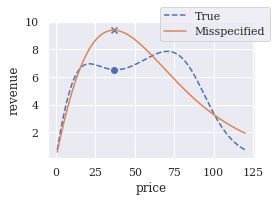

In [132]:
a = np.asarray([[1], [9]])
b = np.asarray([0.1])
w = np.asarray([0.825, 0.125])

# a = np.asarray([[0.5], [4]])
# b = np.asarray([0.1])
# w = np.asarray([0.5, 0.5])

example = MisspecificationExample(a, b, w)
price_range = (1, 120)

observed_prices, observed_choices = example.simulate_choices(5000, price_range)

# estimate a misspecified logit model
start_parameters = np.random.uniform(0, 1, size=2)
args = (observed_choices, observed_prices)
min_problem = minimize(likelihood, start_parameters, args=args)

def revenue_misspecified(a, b, p):
    return np.sum(p * np.exp(a - b * p) / (1 + np.exp(a - b * p)))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="overflow encountered in exp") 
    a, b = min_problem.x
assert min_problem.success


_, ax = plt.subplots(figsize=(4, 3))

price_grid = np.linspace(*price_range, 1000)
true_rev = [example.revenue_true(p) for p in price_grid]
ax.plot(price_grid, true_rev, label='True', linestyle='--')

wrong_rev = [revenue_misspecified(a, b, p) for p in price_grid]
ax.plot(price_grid, wrong_rev, label='Misspecified')

opt_price_idx = np.argmax(wrong_rev)
best_price_wrong = price_grid[opt_price_idx]
best_rev_wrong = wrong_rev[opt_price_idx]
best_rev_true = true_rev[opt_price_idx]
ax.scatter(best_price_wrong, best_rev_wrong, marker='x', color='b')
ax.scatter(best_price_wrong, best_rev_true, marker='o', color='b')

plt.legend()
ax.legend(bbox_to_anchor=(1.1, 1.15))
plt.ylabel(r'revenue')
plt.xlabel(f'price')
plt.tight_layout()
plt.savefig('../figs/misspecification_example.pdf')
plt.show()



In [133]:
best_rev_true

6.526092842497931

37

In [123]:
a, b

(0.2738860597858031, 0.036588286220606704)